# 06 Markowitz Model Implementation
## Import Python Modules

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from seaborn import heatmap 
import scipy.optimize as optimization

## Lecture 1 - Downloading and Summarizing Data

In [2]:
def download_data(stocks: list[str], start_date: str, end_date: str) -> pd.DataFrame:
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)["Close"]
    return pd.DataFrame(stock_data)

In [3]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252

# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

# historical data - define START and END dates
start_date = '2012-01-01'
end_date = '2017-01-01'

data = download_data(stocks, start_date, end_date)
data.head()

,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2012-01-03 00:00:00-05:00,12.482926,46.785141,1.872000,86.152100,8.9515,31.421198
2012-01-04 00:00:00-05:00,12.550010,46.304329,1.847333,87.090569,8.8755,30.474543
2012-01-05 00:00:00-05:00,12.689342,46.079449,1.808000,87.043655,8.8805,28.581226
2012-01-06 00:00:00-05:00,12.821994,45.753742,1.794000,87.512894,9.1305,27.027124
2012-01-09 00:00:00-05:00,12.801654,45.893314,1.816667,88.498276,8.9280,26.538019


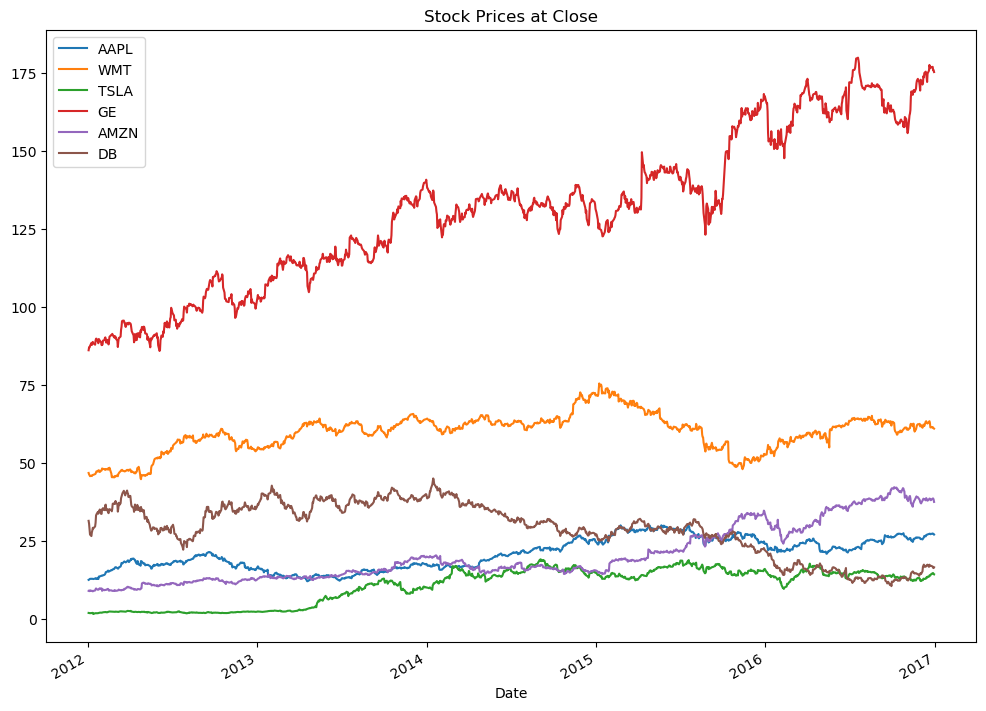

In [4]:
data.plot(figsize=(12, 9), title="Stock Prices at Close");

## Lecture 2 - Caculate Returns & Statistics

In [5]:
def calculate_log_daily_return(data: pd.DataFrame) -> np.ndarray:
    # today's stock price over yesterday's stock price
    # return = ln( S(t) / S(t-1) )
    log_return = np.log(data / data.shift(1))
    return log_return[1:]


def show_statistics(returns: np.ndarray, n_trading_days: int):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print("Returns:")
    print(returns.mean() * n_trading_days)
    print()
    print("Covariance:")
    print(returns.cov() * n_trading_days)


def show_mean_variance(returns: np.ndarray, weights: np.ndarray, n_trading_days: int) -> tuple[float, float]:
    # we want the annual return
    portfolio_return = np.sum(returns.mean() * weights) * n_trading_days
    portfolio_volatility = np.sqrt(
        np.dot(weights.T, np.dot(returns.cov() * n_trading_days, weights))
    )
    # print("Expected portfolio mean (return): ", portfolio_return)
    # print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)
    return portfolio_return, portfolio_volatility

In [6]:
log_returns = calculate_log_daily_return(data)
show_statistics(log_returns, NUM_TRADING_DAYS)

Returns:
AAPL    0.154803
WMT     0.053214
TSLA    0.406862
GE      0.142554
AMZN    0.287153
DB     -0.128913
dtype: float64

Covariance:
          AAPL       WMT      TSLA        GE      AMZN        DB
AAPL  0.068351  0.008142  0.025434  0.014196  0.019009  0.024571
WMT   0.008142  0.028017  0.010265  0.009221  0.008545  0.013247
TSLA  0.025434  0.010265  0.252700  0.019334  0.041774  0.039047
GE    0.014196  0.009221  0.019334  0.032647  0.018026  0.031347
AMZN  0.019009  0.008545  0.041774  0.018026  0.094476  0.031574
DB    0.024571  0.013247  0.039047  0.031347  0.031574  0.139114


<Axes: title={'center': 'Covariance Matrix of Stock Returns'}>

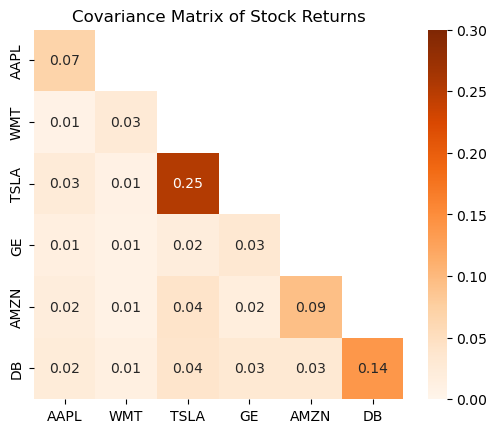

In [7]:
cov_matrix = log_returns.cov()*NUM_TRADING_DAYS
plt.title("Covariance Matrix of Stock Returns")
heatmap(
    cov_matrix, annot=True, square=True, fmt=".2f", vmin=0, vmax=0.3, cmap="Oranges", mask=np.triu(cov_matrix, 1)
)

In [8]:
weights = np.array([0.16]*6)
show_mean_variance(log_returns, weights,NUM_TRADING_DAYS)

(0.14650779767541158, 0.1783675493489424)

## Lecture 3 - Generating Many Portfolios

In [9]:
def generate_portfolios(returns, stocks, n_portfolios, n_trading_days):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weigths = []

    for _ in range(n_portfolios):
        w = np.random.random(len(stocks))
        w /= np.sum(w) # normalize as %
        portfolio_weigths.append(w)
        mu, sigma = show_mean_variance(returns, w, n_trading_days)
        portfolio_means.append(mu)
        portfolio_risks.append(sigma)
        portfolio_weigths.append(
            np.sqrt(np.dot(w.T, np.dot(returns.cov() * n_trading_days, w)))
        )

    return (
        np.array(portfolio_means),
        np.array(portfolio_risks),
        np.array(portfolio_weigths),
    )


def sharpe_plot(returns, volatilities):
    plt.figure(figsize=(10,6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker=".")
    plt.grid(alpha=0.33)
    plt.title("Simulated Portfolios: Efficient Frontier Plot")
    plt.xlabel("Expected Volatility")
    plt.ylabel("Expected Return")
    plt.colorbar(label="Sharpe Ratio");

C:\Users\TWalter\AppData\Local\Temp\ipykernel_25780\748323745.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(portfolio_weigths),


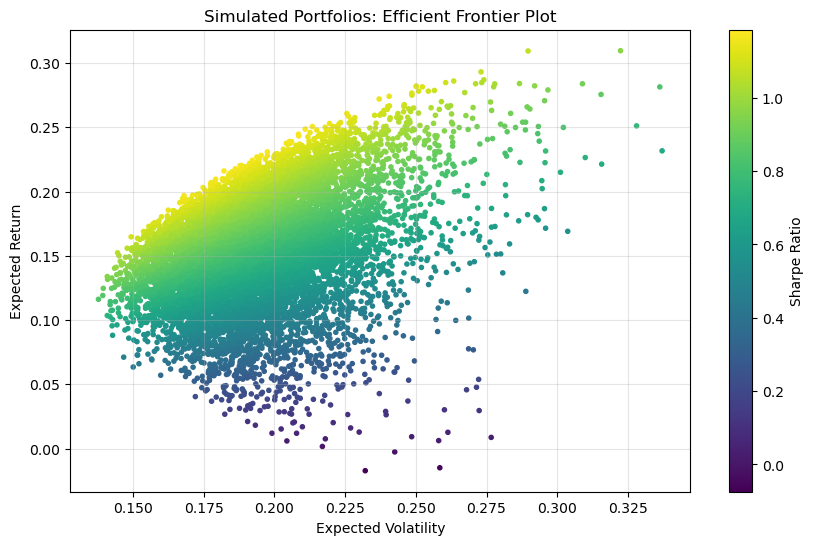

In [10]:
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10_000

np.random.seed(2020)
means, risks, p_weights = generate_portfolios(
    log_returns, stocks, NUM_PORTFOLIOS, NUM_TRADING_DAYS
)
sharpe_plot(means, risks)

## Lecture 4 - Choosing the Optimal Portfolio

In [11]:
def portfolio_statistics(weights: np.ndarray, returns: np.ndarray) -> np.ndarray:
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(
        np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights))
    )
    # last value is Sharpe ratio = r_t / s_t
    return np.array([portfolio_return, portfolio_volatility, (portfolio_return/portfolio_volatility)])

# scipy optimize module can find the minimum of a given function
# the maximim of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights: np.ndarray, returns: np.ndarray):
    return -portfolio_statistics(weights, returns)[2]

# what are the constraints? sum of weights = 1.0
# and weight bounds 0.0 <= w_i <= 1.0 for any given stock S_i
# f(x)=0 this the function to minimize
def optimize(n_stocks: int, weights: np.ndarray, returns: np.ndarray) -> optimization.OptimizeResult:
    constraints = {"type": "eq", "fun": lambda x: np.sum(x)-1}
    bounds = tuple((0, 1) for _ in range(n_stocks))
    solution = optimization.minimize(fun=min_function_sharpe, x0=weights[0],
                                     args=returns, method="SLSQP", constraints=constraints, bounds=bounds)
    # acces solution["x"]
    return solution

def print_optimal_portfolio(solution: optimization.OptimizeResult, stocks: list[str], returns: np.ndarray):
    weights = solution["x"]
    mu, sigma, sharpe = portfolio_statistics(weights, returns)
    portfolio = [(s, round(w, 3)) for s, w in zip(stocks, weights)]

    print(f"Optimal Portfolio:\n{portfolio}\n") 
    print(f"Expected Return: {mu:.3f}")
    print(f"Volatility: {sigma:.3f}")
    print(f"Sharpe Ratio: {sharpe:.3f}")


In [12]:
solution = optimize(len(stocks), p_weights, log_returns)

print_optimal_portfolio(solution, stocks, log_returns)

Optimal Portfolio:
[('AAPL', 0.139), ('WMT', 0.0), ('TSLA', 0.166), ('GE', 0.373), ('AMZN', 0.321), ('DB', 0.0)]

Expected Return: 0.235
Volatility: 0.195
Sharpe Ratio: 1.201


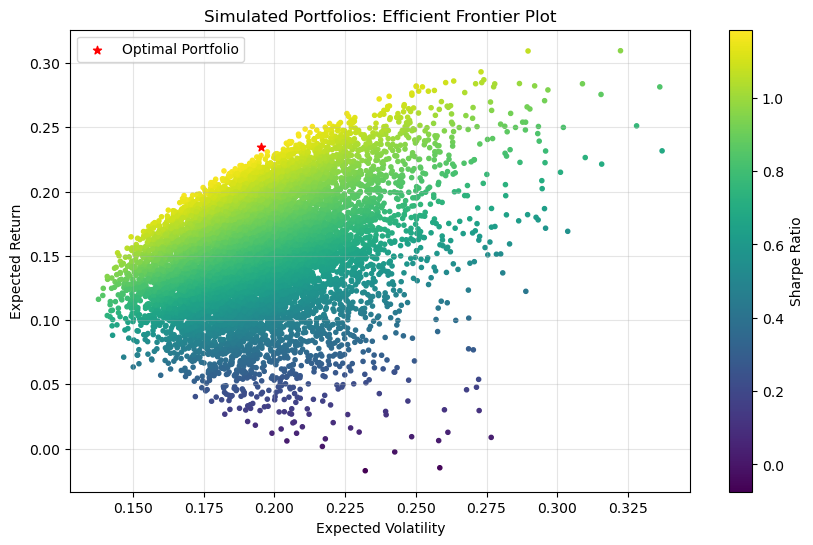

In [13]:
op_weights = solution["x"]
mu, sigma, sharpe = portfolio_statistics(op_weights, log_returns)
sharpe_plot(means, risks)
plt.scatter(sigma, mu, marker="*", c="r", label="Optimal Portfolio")
plt.legend();